Logistic Regression Model. Has Glove, N-gram, and TFIDF model options. Just commment out each section. 

In [1]:
import numpy as np
import nltk
nltk.download('punkt')
from nltk.corpus import wordnet
import string
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import os
from sklearn.metrics import f1_score
import random
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


PREPROCESSING FUNCTIONS

In [2]:
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
lemmatizer = nltk.WordNetLemmatizer()

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
def lemmatizer(text):
  lemm_text = []
  for word in text:
    lemm_text.append(wordnet_lemmatizer.lemmatize(word))
  return lemm_text
def lemmatizer_dataset(dataset):
  lemm_text = []
  for review in dataset:
    words = word_tokenize(review)
    lemm_text.append(' '.join(lemmatizer(words)))
  return lemm_text

In [4]:
def lowerCase(StringArray):
    lowerArray = []
    for i in StringArray:
        lowerArray.append(i.lower())
    return lowerArray

In [5]:
def depunctuate(StringArray):
    exclude = set(string.punctuation)
    depStringArray = []
    for i in StringArray:
        s = ''.join(ch for ch in i if ch not in exclude)
        depStringArray.append(s)
    return depStringArray

In [6]:
def splitData(Div, StringArray, Labels):
    splitArray = []
    for i, x in enumerate(StringArray):
        if Labels[i] == Div:
            splitArray.append(x)
    return splitArray

In [7]:
def removeStop(StringArray):
  filtered_sentences = []
  for sample in StringArray:
    words = word_tokenize(sample)
    filtered_words = []
    for word in words:
      if word not in stop_words:
        filtered_words.append(word)
    filtered_sentences.append(' '.join(filtered_words))
  return filtered_sentences

I forgot to remove this Ngram functino cause we don't actually use it. We just use the direct implementation in the vectorizer. We can keep it for now just in case

In [ ]:
def Lemma(Dtrain):
    
    tokensArray = []
    for i in Dtrain:
        tokensArray.append(word_tokenize(i))
    Lemmatized = []
    for k, s in enumerate(tokensArray):
        Sentence = []
        for w in s:
            Sentence.append(lemmatizer.lemmatize(w, get_wordnet_pos(w)))
            NTsentence = (" ").join(Sentence)
        Lemmatized.append(NTsentence)
    return Lemmatized

In [8]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

WORD2VEC VECTORIZER CLASS

In [9]:
class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

In [10]:
def sentenceAvg(sentence, wordVectorMap):
    words = sentence.lower().split()
    avg = np.zeros(50)
    for w in words:
        if w in wordVectorMap:
            avg+= wordVectorMap[w]
    avg = avg/ len(words)
    return avg

In [11]:
def read_glove_vecs(glove_file):
    with open(glove_file, encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [12]:
def checkUnique(n, randomList):
    for i in randomList:
        if n  == i:
            return False
    return True

In [13]:
def ScaleTrainSet(Xtrain, Ytrain, scale):
    randomlist = []
    for i in range(1, scale):
        n = random.randint(1, len(Xtrain)-1)
        while (checkUnique(n, randomlist) == False):
            n = random.randint(1, len(Xtrain)-1)
        randomlist.append(n)
    XtrainScaled = []
    YtrainScaled = []
    for i in randomlist:
        XtrainScaled.append(Xtrain[i])
        YtrainScaled.append(Ytrain[i])
    return XtrainScaled, YtrainScaled

NGRAM MODEL USED FOR LOGISTIC REGRESSION

In [14]:
def NgramModel(Dtrain, Dlabels, iter, TrainSize):
    BestX = []
    bestPred = 0
    DtrainPos = splitData(1, Dtrain, Dlabels)
    DtrainNeg = splitData(0, Dtrain, Dlabels)
    ### Converting for LR input ###
    Dtrain = np.concatenate((np.array(DtrainPos), np.array(DtrainNeg)), axis=0)
    Dtrain = Dtrain.tolist()
    vectorizer1 = CountVectorizer(ngram_range=(1, 5))
    vectorizer1 = CountVectorizer()
    AvgScore = 0
    for i in range(iter):
        vectorizer1.fit(Dtrain)
        vector1 = vectorizer1.transform(Dtrain)
        X = vector1.toarray()
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, [1] * len(DtrainPos) + [0] * len(DtrainNeg), test_size=0.20)
        Xtrain, Ytrain = ScaleTrainSet(Xtrain, Ytrain, TrainSize)
        ### LR Model ###
        clf = LogisticRegression(random_state=0, max_iter=10000).fit(Xtrain, Ytrain)
        y_pred = clf.predict(Xtest)
        predScore = f1_score(y_pred, Ytest)
        AvgScore =  AvgScore + predScore
        #predScore = accuracy_score(y_pred, Ytest)
        
        if predScore > bestPred:
            bestPred = predScore
            BestX = [Xtrain, Xtest, Ytrain, Ytest] 
            #print('Logistic Regression F1 Score: %s' % f1_score(y_pred, Ytest))
            #print('Logistic Regression accuracy: %s' % accuracy_score(y_pred, Ytest))
    AvgScore = AvgScore/iter
    return BestX[0],BestX[1],BestX[2],BestX[3], AvgScore

In [15]:
def GloveModel(Dtrain, Dlabels, model, iter, TrainSize):
    BestX = []
    bestPred = 0
    DtrainPos = splitData(1, Dtrain, Dlabels)
    DtrainNeg = splitData(0, Dtrain, Dlabels)
    Dtrain = np.concatenate((np.array(DtrainPos), np.array(DtrainNeg)), axis=0)
    Dtrain = Dtrain.tolist() 
          ## Glove ###
    word_to_index, index_to_word, word_to_vec_map = read_glove_vecs("/content/drive/MyDrive/COMP550 Final Project/glove.6B.50d.txt")
    vectorizer = Word2VecVectorizer(model) #### Creating Vectorizer i.e converting word embeddings to LR input

    AvgScore = 0
    for i in range(iter):
      Xtrain, Xtest, Ytrain, Ytest = train_test_split(Dtrain, [1] * len(DtrainPos) + [0] * len(DtrainNeg), test_size=0.20)
      # Sentence Averaging
      for i, sent in enumerate(Xtrain):
        avg = sentenceAvg(sent, word_to_vec_map)
        #print(avg)
        Xtrain[i] = avg

  # Get the sentence embeddings for the test dataset
      Xtest = vectorizer.transform(Xtest)
  ### Converting for LR input ###
      ### Scaling to TrainingSets to TrainSize
      Xtrain, Ytrain = ScaleTrainSet(Xtrain, Ytrain, TrainSize)
      ### LR Model ###
      for x in Xtrain:
        x = x[np.logical_not(np.isnan(x))]
      clf = LogisticRegression(random_state=0, max_iter=10000).fit(Xtrain, Ytrain)
      y_pred = clf.predict(Xtest)
      predScore = f1_score(y_pred, Ytest)
      AvgScore =  AvgScore + predScore
      #predScore = accuracy_score(y_pred, Ytest)
      
      if predScore > bestPred: ### Don't really need this for what we do but if you wan't to find the best Xtrain Split this will give it to you
          bestPred = predScore
          BestX = [Xtrain, Xtest, Ytrain, Ytest] 
          #print('Logistic Regression F1 Score: %s' % f1_score(y_pred, Ytest))
          #print('Logistic Regression accuracy: %s' % accuracy_score(y_pred, Ytest))
    AvgScore = AvgScore/iter
    return BestX[0],BestX[1],BestX[2],BestX[3], AvgScore
    

TFIDF MODEL USED FOR LOGISTIC REGRESSION

In [16]:
def tfidfModel(Dtrain, Dlabels, iter, TrainSize): 
    BestX = []
    bestPred = 0
    DtrainPos = splitData(1, Dtrain, Dlabels)
    DtrainNeg = splitData(0, Dtrain, Dlabels)
    ### Converting for LR input ###
    Dtrain = np.concatenate((np.array(DtrainPos), np.array(DtrainNeg)), axis=0)
    Dtrain = Dtrain.tolist()
    tf_idf = TfidfVectorizer()
    tf_idf.fit(Dtrain)
    vector = tf_idf.transform(Dtrain)
    X = vector.toarray()
    AvgScore = 0
    for i in range(iter):
 
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, [1] * len(DtrainPos) + [0] * len(DtrainNeg), test_size=0.20)
        Xtrain, Ytrain = ScaleTrainSet(Xtrain, Ytrain, TrainSize)
        ### LR Model ###
        clf = LogisticRegression(random_state=0, max_iter=10000).fit(Xtrain, Ytrain)
        y_pred = clf.predict(Xtest)
        #predScore = accuracy_score(y_pred, Ytest)
        predScore = f1_score(y_pred, Ytest)
        AvgScore =  AvgScore + predScore

        # print('Accuracy: %s' % accuracy_score(y_pred, Ytest))
        if predScore > bestPred:
            bestPred = predScore
            BestX = [Xtrain, Xtest, Ytrain, Ytest]
            #print('Logistic Regression F1 Score: %s' % f1_score(y_pred, Ytest))
            #print('Logistic Regression accuracy: %s' % accuracy_score(y_pred, Ytest))
    AvgScore = AvgScore/iter
    return BestX[0],BestX[1],BestX[2],BestX[3], AvgScore

MAIN METHOD FOR RUNNING LINEAR REGRESSION 

In [ ]:
import pandas as pd

In [17]:
path_data = "/content/drive/MyDrive/COMP550 Final Project/IMDB.csv"
df = pd.read_csv(path_data)
Y = pd.Series.to_numpy(df['Label'])
X = pd.Series.to_numpy(df['Sentences'])

NameError: ignored

In [ ]:
index = 0
split = 16
Dlabels = []
Dtrain = []
for sentence in X:
  if index % split == 0:
    Dtrain.append(sentence)
    Dlabels.append(Y[index])
  index +=1

In [ ]:
print(len(Dlabels))

3125


In [18]:
Dtrain = open("/content/drive/MyDrive/COMP550 Final Project/TrainingData.txt")
Dlabels = open("/content/drive/MyDrive/COMP550 Final Project/TrainingLabels.txt")
Dlabels= np.loadtxt(Dlabels, delimiter="\n")


Calling Preprocessing

In [21]:
  # load the Stanford GloVe model

### Seting up Glove ###
glove_filename = 'glove.6B.50d.txt'
# Variable for data directory
glove_path = '/content/drive/MyDrive/COMP550 Final Project/glove.6B.50d.txt'
word2vec_output_file = glove_filename + '.word2vec'
glove2word2vec(glove_path, word2vec_output_file)
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
######### Preprocessing Steps ##############

        ### Convert to Lower Case ###
Dtrain = lowerCase(Dtrain)
        ### Depunctuating ###
Dtrain = depunctuate(Dtrain)
DtrainGlove = Dtrain ### don't want to remove stop words etc
        ### Removing Stopwords ###
Dtrain  = removeStop(Dtrain)  ###Btw might be fixable but this thing takes ages!
        ### Lemmatizing ###
Dtrain = lemmatizer_dataset(Dtrain)
                                                                #Dtrain  = Lemma(Dtrain) 
#print(Dtrain)

LOGISTIC REGRESSION TESTING

In [22]:

        ### Splitting Dtrain ###
DtrainPos = splitData(1, Dtrain, Dlabels)
print(DtrainPos)
DtrainNeg = splitData(0, Dtrain, Dlabels)
######## Converting for LR input ########
AvgScoreNgram = []
AvgScoreTFIDF = []
AvgScoreGlove = []


  # clf = LogisticRegression(random_state=0, max_iter=10000).fit(Xtrain, Ytrain)
  # y_pred = clf.predict(Xtest)
  # print('BestAccuracy: %s' % accuracy_score(y_pred, Ytest))
  # print('Best F1 score: %s' % f1_score(y_pred, Ytest))



  

['woman good', 'dress sexy sign contract', 'period', 'stop bitchy', 'leave early child instead husband', 'thank quota', 'would never get job woman', 'woman thing', 'emotional', 'wear dress', 'wear skirt', 'high heel mandatory', 'act like girl think like man', 'woman empowerment begin home', 'planning child', 'youre still married', 'marry later better career', 'feminist', 'high position better suit men', 'fault woman', 'woman take care running home', 'leave running company men', 'woman problem', 'kiss would shame deprive', 'ill explain simple word understand', 'know hired', 'dont worry husband making good living', 'fortunately earn boyfriend', 'youre pregnant thought motivated', 'recruited new commercial nice woman', 'man project absolutely want woman asking', 'try promote woman although file technical', 'feel able take task', 'wont go get u coffee', 'patriarchal company', 'weakness woman issue', 'work men', 'woman homemaker', 'men made work hard woman homemaker', 'men speaker woman wri

In [ ]:
for i in range(55): #### Do this for however many points you want to graph (i.e Data set sizes) Then Choose if you want Ngrams TFIDF or Glove Model - Need to change preprocessing accordingly
          ### Ngrams ###
  Xtrain, Xtest, Ytrain, Ytest, AvgScore = NgramModel(Dtrain, Dlabels, 20, i*16+20) # (Dtrain, Dlabels, Iterations, Training set size)
  print('Avg F1 Score: %s' % AvgScore)
  AvgScoreNgram.append(AvgScore)
          ### Ngrams ###




In [ ]:
for i in range(55):
          ### TFIDF ### 
  Xtrain1, Xtest1, Ytrain1, Ytest1, AvgScore1 = tfidfModel(Dtrain, Dlabels, 20, (i*16)+20) # (Dtrain, Dlabels, Iterations, Training set size)
  print('Avg F1 Score: %s' % AvgScore1)
  AvgScoreTFIDF.append(AvgScore1)
          ### TFIDF ###



In [ ]:

for i in range(55):
          ### Glove ###
  Xtrain2, Xtest2, Ytrain2, Ytest2, AvgScore2 = GloveModel(DtrainGlove, Dlabels, model, 20, i*16+20) # (Dtrain, Dlabels, Iterations, Training set size)
  print('Avg F1 Score: %s' % AvgScore2)
  AvgScoreGlove.append(AvgScore2)
          ### Glove ###

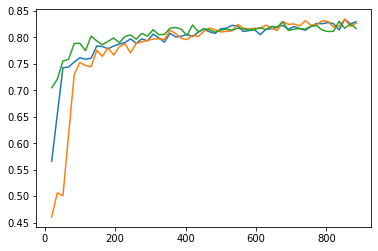

In [ ]:

Xaxis = []
for i in range(55):
  Xaxis.append(i*16+20)
plt.plot(Xaxis, AvgScoreNgram) # plotting by columns
plt.plot(Xaxis, AvgScoreTFIDF)
plt.plot(Xaxis, AvgScoreGlove)

plt.savefig("High resoltion.png",dpi=600)
plt.show()



---


**NAIVE BAYES IMPLEMENTATION**

---



Naive Bayes Model, pretty much the same as LR. Still need to add GLove but not sure we need it.

NGRAM MODEL FOR NAIVE BAYES

In [ ]:
def NgramModelNB(Dtrain, Dlabels, iter, TrainSize):
    BestX = []
    bestPred = 0
    DtrainPos = splitData(1, Dtrain, Dlabels)
    DtrainNeg = splitData(0, Dtrain, Dlabels)
    ### Converting for LR input ###
    Dtrain = np.concatenate((np.array(DtrainPos), np.array(DtrainNeg)), axis=0)
    Dtrain = Dtrain.tolist()
    vectorizer1 = CountVectorizer(ngram_range=(1, 5))
    vectorizer1 = CountVectorizer()
    AvgScore = 0
    for i in range(iter):
        vectorizer1.fit(Dtrain)
        vector1 = vectorizer1.transform(Dtrain)
        X = vector1.toarray()
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, [1] * len(DtrainPos) + [0] * len(DtrainNeg), test_size=0.20)
        Xtrain, Ytrain = ScaleTrainSet(Xtrain, Ytrain, TrainSize)
        ### LR Model ###
                ### NB Model ###
        gnb = GaussianNB()
        gnb.fit(Xtrain, Ytrain)
        
        #predScore = gnb.score(Xtest, Ytest)
        y_pred = gnb.predict(Xtest)
        predScore = f1_score(y_pred, Ytest)
        
        AvgScore =  AvgScore + predScore
        #predScore = accuracy_score(y_pred, Ytest)
        
        if predScore > bestPred:
            bestPred = predScore
            BestX = [Xtrain, Xtest, Ytrain, Ytest] 
            #print('Logistic Regression F1 Score: %s' % f1_score(y_pred, Ytest))
            #print('Logistic Regression accuracy: %s' % accuracy_score(y_pred, Ytest))
    AvgScore = AvgScore/iter
    return BestX[0],BestX[1],BestX[2],BestX[3], AvgScore

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


TFIDF MODEL FOR NAIVE BAYES

In [ ]:
def tfidfModelNB(Dtrain, Dlabels, iter, TrainSize):
    BestX = []
    bestPred = 0
    DtrainPos = splitData(1, Dtrain, Dlabels)
    DtrainNeg = splitData(0, Dtrain, Dlabels)
    ### Converting for LR input ###
    Dtrain = np.concatenate((np.array(DtrainPos), np.array(DtrainNeg)), axis=0)
    Dtrain = Dtrain.tolist()
    tf_idf = TfidfVectorizer()
    tf_idf.fit(Dtrain)
    vector = tf_idf.transform(Dtrain)
    X = vector.toarray()
    AvgScore = 0
    for i in range(iter):
 
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, [1] * len(DtrainPos) + [0] * len(DtrainNeg), test_size=0.20)
        Xtrain, Ytrain = ScaleTrainSet(Xtrain, Ytrain, TrainSize)
        ### NB Model ###
        gnb = GaussianNB()
        gnb.fit(Xtrain, Ytrain)
        
        #predScore = gnb.score(Xtest, Ytest)
        y_pred = gnb.predict(Xtest)
        predScore = f1_score(y_pred, Ytest)
        AvgScore =  AvgScore + predScore

        # print('Accuracy: %s' % accuracy_score(y_pred, Ytest))
        if predScore > bestPred:
            bestPred = predScore
            BestX = [Xtrain, Xtest, Ytrain, Ytest]
            #print('Logistic Regression F1 Score: %s' % f1_score(y_pred, Ytest))
            #print('Logistic Regression accuracy: %s' % accuracy_score(y_pred, Ytest))
    AvgScore = AvgScore/iter
    return BestX[0],BestX[1],BestX[2],BestX[3], AvgScore

In [24]:
def GloveModelNB(Dtrain, Dlabels, model, iter, TrainSize):
    BestX = []
    bestPred = 0
    DtrainPos = splitData(1, Dtrain, Dlabels)
    DtrainNeg = splitData(0, Dtrain, Dlabels)
    Dtrain = np.concatenate((np.array(DtrainPos), np.array(DtrainNeg)), axis=0)
    Dtrain = Dtrain.tolist() 
          ## Glove ###
    word_to_index, index_to_word, word_to_vec_map = read_glove_vecs("/content/drive/MyDrive/COMP550 Final Project/glove.6B.50d.txt")
    vectorizer = Word2VecVectorizer(model) #### Creating Vectorizer i.e converting word embeddings to LR input

    AvgScore = 0
    for i in range(iter):
      Xtrain, Xtest, Ytrain, Ytest = train_test_split(Dtrain, [1] * len(DtrainPos) + [0] * len(DtrainNeg), test_size=0.20)
      # Sentence Averaging
      for i, sent in enumerate(Xtrain):
        avg = sentenceAvg(sent, word_to_vec_map)
        #print(avg)
        Xtrain[i] = avg

  # Get the sentence embeddings for the test dataset
      Xtest = vectorizer.transform(Xtest)
  ### Converting for LR input ###
      ### Scaling to TrainingSets to TrainSize
      Xtrain, Ytrain = ScaleTrainSet(Xtrain, Ytrain, TrainSize)
      ### NB Model ###
      gnb = GaussianNB()
      gnb.fit(Xtrain, Ytrain)
        
        #predScore = gnb.score(Xtest, Ytest)
      y_pred = gnb.predict(Xtest)
      predScore = f1_score(y_pred, Ytest)
      AvgScore =  AvgScore + predScore
      
      if predScore > bestPred: ### Don't really need this for what we do but if you wan't to find the best Xtrain Split this will give it to you
          bestPred = predScore
          BestX = [Xtrain, Xtest, Ytrain, Ytest] 
          #print('Logistic Regression F1 Score: %s' % f1_score(y_pred, Ytest))
          #print('Logistic Regression accuracy: %s' % accuracy_score(y_pred, Ytest))
    AvgScore = AvgScore/iter
    return BestX[0],BestX[1],BestX[2],BestX[3], AvgScore
    

**NAIVE BAYES MAIN**

In [ ]:


AvgScoreNgramNB = []
for i in range(55): #### Do this for however many points you want to graph (i.e Data set sizes) Then Choose if you want Ngrams TFIDF or Glove Model - Need to change preprocessing accordingly
          ### Ngrams ###
  Xtrain, Xtest, Ytrain, Ytest, AvgScore = NgramModelNB(Dtrain, Dlabels, 20, i*16+20) # (Dtrain, Dlabels, Iterations, Training set size)
  print('Avg F1 Score: %s' % AvgScore)
  AvgScoreNgramNB.append(AvgScore)
          ### Ngrams ###
print(AvgScoreNgramNB)

In [ ]:
AvgScoreTFIDFNB = []
for i in range(55):
          ### TFIDF ### 
  Xtrain1, Xtest1, Ytrain1, Ytest1, AvgScore1 = tfidfModelNB(Dtrain, Dlabels, 20, i*16+20) # (Dtrain, Dlabels, Iterations, Training set size)
  print('Avg F1 Score: %s' % AvgScore1)
  AvgScoreTFIDFNB.append(AvgScore1)
          ### TFIDF ###
print(AvgScoreTFIDFNB)

In [ ]:
AvgScoreGloveNB= []
for i in range(55):
          ### Glove ### 
  Xtrain2, Xtest2, Ytrain2, Ytest2, AvgScore2 = GloveModelNB(DtrainGlove, Dlabels, model, 20, i*16+20) # (Dtrain, Dlabels, Iterations, Training set size)
  print('Avg F1 Score: %s' % AvgScore2)
  AvgScoreGloveNB.append(AvgScore2)
          ### Glove ###
print(AvgScoreGloveNB)

55


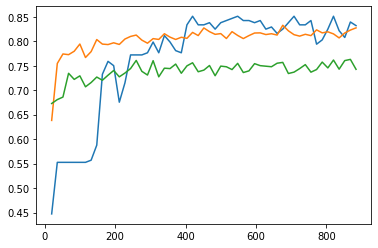

In [26]:
VanillaSTMResults = [0.4473684210526316, 0.4473684210526316, 0.4473684210526316, 0.5263157894736842, 0.5394736842105263, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5526315789473685, 0.5570175438596491, 0.5570175438596491, 0.5570175438596491, 0.5570175438596491, 0.5614035087719298, 0.5745614035087719, 0.5877192982456141, 0.5921052631578947, 0.6271929824561403, 0.6578947368421053, 0.7105263157894737, 0.7324561403508771, 0.7543859649122807, 0.7631578947368421, 0.7587719298245614, 0.7587719298245614, 0.7587719298245614, 0.75, 0.7456140350877193, 0.7456140350877193, 0.7368421052631579, 0.75, 0.7543859649122807, 0.75, 0.7368421052631579, 0.7105263157894737, 0.6754385964912281, 0.6491228070175439, 0.6491228070175439, 0.6710526315789473, 0.706140350877193, 0.7149122807017544, 0.7324561403508771, 0.75, 0.7587719298245614, 0.7631578947368421, 0.7719298245614035, 0.7807017543859649, 0.7675438596491229, 0.7631578947368421, 0.7631578947368421, 0.7719298245614035, 0.7675438596491229, 0.7719298245614035, 0.7807017543859649, 0.7719298245614035, 0.7719298245614035, 0.7543859649122807, 0.7587719298245614, 0.7631578947368421, 0.7675438596491229, 0.7763157894736842, 0.7894736842105263, 0.7850877192982456, 0.7982456140350878, 0.7894736842105263, 0.7982456140350878, 0.7850877192982456, 0.7894736842105263, 0.7719298245614035, 0.7719298245614035, 0.7763157894736842, 0.7763157894736842, 0.7807017543859649, 0.7894736842105263, 0.8026315789473685, 0.8114035087719298, 0.8157894736842105, 0.8201754385964912, 0.7982456140350878, 0.7982456140350878, 0.7982456140350878, 0.8026315789473685, 0.8026315789473685, 0.8026315789473685, 0.7894736842105263, 0.7807017543859649, 0.7719298245614035, 0.7631578947368421, 0.7631578947368421, 0.7631578947368421, 0.7763157894736842, 0.7894736842105263, 0.7982456140350878, 0.8157894736842105, 0.8157894736842105, 0.8333333333333334, 0.8333333333333334, 0.8421052631578947, 0.8421052631578947, 0.8377192982456141, 0.8508771929824561, 0.8377192982456141, 0.8289473684210527, 0.8157894736842105, 0.8245614035087719, 0.8333333333333334, 0.8289473684210527, 0.8289473684210527, 0.8289473684210527, 0.8333333333333334, 0.8333333333333334, 0.8289473684210527, 0.8333333333333334, 0.8201754385964912, 0.8245614035087719, 0.8377192982456141, 0.8333333333333334, 0.8333333333333334, 0.8377192982456141, 0.8377192982456141, 0.8245614035087719, 0.8289473684210527, 0.8333333333333334, 0.8421052631578947, 0.8421052631578947, 0.8377192982456141, 0.8421052631578947, 0.8421052631578947, 0.8552631578947368, 0.8508771929824561, 0.8421052631578947, 0.8289473684210527, 0.8245614035087719, 0.8201754385964912, 0.8289473684210527, 0.8464912280701754, 0.8552631578947368, 0.8508771929824561, 0.8464912280701754, 0.8421052631578947, 0.8508771929824561, 0.8552631578947368, 0.8464912280701754, 0.8464912280701754, 0.8421052631578947, 0.8421052631578947, 0.8333333333333334, 0.8289473684210527, 0.8289473684210527, 0.8421052631578947, 0.8421052631578947, 0.8421052631578947, 0.8421052631578947, 0.8333333333333334, 0.8377192982456141, 0.8377192982456141, 0.8377192982456141, 0.8464912280701754, 0.8464912280701754, 0.8377192982456141, 0.8421052631578947, 0.8333333333333334, 0.8333333333333334, 0.8289473684210527, 0.8245614035087719, 0.8245614035087719, 0.8245614035087719, 0.8245614035087719, 0.8201754385964912, 0.8245614035087719, 0.8289473684210527, 0.8289473684210527, 0.8289473684210527, 0.8289473684210527, 0.8245614035087719, 0.8157894736842105, 0.8201754385964912, 0.8157894736842105, 0.8245614035087719, 0.8245614035087719, 0.8245614035087719, 0.8289473684210527, 0.8289473684210527, 0.8333333333333334, 0.8421052631578947, 0.8377192982456141, 0.8377192982456141, 0.8333333333333334, 0.8421052631578947, 0.8421052631578947, 0.8508771929824561, 0.8464912280701754, 0.8289473684210527, 0.8157894736842105, 0.8157894736842105, 0.8333333333333334, 0.8421052631578947, 0.8377192982456141, 0.8421052631578947, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8421052631578947, 0.8421052631578947, 0.8421052631578947, 0.8421052631578947, 0.8421052631578947, 0.8377192982456141, 0.8377192982456141, 0.8201754385964912, 0.793859649122807, 0.8070175438596491, 0.8114035087719298, 0.8070175438596491, 0.8026315789473685, 0.8026315789473685, 0.8026315789473685, 0.8026315789473685, 0.8026315789473685, 0.8157894736842105, 0.8245614035087719, 0.8070175438596491, 0.8026315789473685, 0.8201754385964912, 0.8421052631578947, 0.8508771929824561, 0.8552631578947368, 0.8421052631578947, 0.8377192982456141, 0.8377192982456141]
#VSTM = VanillaSTMResults[::5]
Xaxis = []
for i in range(55):
  Xaxis.append(i*16+20)
#plt.plot(Xaxis, AvgScoreNgramNB) # plotting by columns
#plt.plot(Xaxis, AvgScoreTFIDFNB)

plt.plot(Xaxis, VSTM)
plt.plot(Xaxis, AvgScoreGlove)
plt.plot(Xaxis, AvgScoreGloveNB)

plt.savefig("High resoltion.png",dpi=600)
plt.show()